# Build a ChatBot


### Set up ML Client

In [1]:

from azure.ai.ml import MLClient,Input, load_component
from azure.identity import DefaultAzureCredential
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

# authenticate
credential = DefaultAzureCredential()

# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id="65a7bb82-b5cd-4770-a41d-be2cf0a96be8",
    resource_group_name="DVSM",
    workspace_name="BertChatBot",
)


In [2]:
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

# update the 'my_path' variable to match the location of where you downloaded the data on your
# local filesystem

my_path = "./kaggle/input/intents.json"
# set the version number of the data asset
v1 = "uci"

my_data = Data(
    name="univeristy-info",
    version=v1,
    description="Questions about college",
    path=my_path,
    type=AssetTypes.URI_FILE,
)

## create data asset if it doesn't already exist:
try:
    data_asset = ml_client.data.get(name="univeristy-info", version=v1)
    print(
        f"Data asset already exists. Name: {my_data.name}, version: {my_data.version}"
    )
except:
    ml_client.data.create_or_update(my_data)
    print(f"Data asset created. Name: {my_data.name}, version: {my_data.version}")

Data asset already exists. Name: univeristy-info, version: uci


In [3]:
%pip install -U azureml-fsspec

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from azure.ai.ml.entities import Environment

custom_env_name = "aml-chatbot-learn"

pipeline_job_env = Environment(
    name=custom_env_name,
    description="Custom environment for Bert Chatbot pipline",
    conda_file= "environment/conda.yaml",
    image="mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04:latest",
    version="2",
)
pipeline_job_env = ml_client.environments.create_or_update(pipeline_job_env)

print(
    f"Environment with name {pipeline_job_env.name} is registered to workspace, the environment version is {pipeline_job_env.version}"
)

<a id="2"></a>
## <b>2 <span style='color:#B21010'>||</span>Import Necessaries</b>

In [2]:
import warnings
warnings.filterwarnings('ignore')
%pip install transformers==4.18.0

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install seaborn
%pip install missingno
%pip install wordcloud
%pip install keras
%pip install tensorflow
%pip install torch
%pip install nltk


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import keras
from tensorflow.keras.preprocessing import text

from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer

2024-05-07 23:55:27.111466: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-07 23:55:32.403210: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 23:55:36.317983: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
%pip install xformers

Note: you may need to restart the kernel to use updated packages.


<a id="3"></a>
## <b>3 <span style='color:#B21010'>||</span> EDA + Vis</b>

<a id="3.1"></a>
### <b>3.1 <span style='color:#B21010'>||</span> Load the data</b>

In [5]:
data_asset = ml_client.data.get("univeristy-info", version="uci")
intents = pd.read_json(data_asset.path)
intents


,intents
0,"{'tag': 'greeting', 'patterns': ['Hi', 'How ar..."
1,"{'tag': 'goodbye', 'patterns': ['cya', 'see yo..."
2,"{'tag': 'creator', 'patterns': ['what is the n..."
3,"{'tag': 'name', 'patterns': ['name', 'your nam..."
4,"{'tag': 'hours', 'patterns': ['timing of colle..."
5,"{'tag': 'number', 'patterns': ['more info', 'c..."
6,"{'tag': 'course', 'patterns': ['list of course..."
7,"{'tag': 'fees', 'patterns': ['information abou..."
8,"{'tag': 'location', 'patterns': ['where is the..."
9,"{'tag': 'hostel', 'patterns': ['hostel facilit..."


<a id="3.2"></a>
### <b>3.2 <span style='color:#B21010'>||</span> Extract Info from the Json data file and Store it in dataframe</b>

In [6]:
def create_df():
    df = pd.DataFrame({
        'Pattern' : [],
        'Tag' : []
    })
    
    return df

df = create_df()
df

,Pattern,Tag


In [7]:
def extract_json_info(json_file, df):
    
    for intent in json_file['intents']:
        
        for pattern in intent['patterns']:
            
            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag
                
    return df

df = extract_json_info(intents, df)
df.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [8]:
df2 = df.copy()
df2.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


<a id="3.3"></a>
### <b>3.3 <span style='color:#B21010'>||</span> Check the shape of the dataset</b>

In [20]:
def print_shape_df(df, ds_name="df"):
    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")
    
print_shape_df(df, "Chatbot")

Chatbot dataset has 390 rows and 2 columns


<a id="3.4"></a>
### <b>3.4 <span style='color:#B21010'>||</span> Display information about the dataset</b>

In [11]:
def print_dfInfo(df, ds_name="df"):
    print(f"The info of {ds_name} dataset\n")
    print(df.info())
    
print_dfInfo(df, "Chatbot")

The info of Chatbot dataset

<class 'pandas.core.frame.DataFrame'>
Index: 390 entries, 0 to 389
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  390 non-null    object
 1   Tag      390 non-null    object
dtypes: object(2)
memory usage: 9.1+ KB
None


<a id="3.5"></a>
### <b>3.5 <span style='color:#B21010'>||</span> Display Number of Classes</b>

In [21]:
def num_classes(df, target_col, ds_name="df"):
    print(f"The {ds_name} dataset has {len(df[target_col].unique())} classes")
    
num_classes(df, 'Tag', "Chatbot")

The Chatbot dataset has 34 classes


<a id="3.6"></a>
### <b>3.6 <span style='color:#B21010'>||</span> Check the null values in the dataset</b>

In [22]:
def check_null(df, ds_name='df'):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())
    
check_null(df, "Chatbot")

Null Values in each col in the Chatbot dataset:

Pattern    0
Tag        0
dtype: int64


<a id="3.7"></a>
### <b>3.7 <span style='color:#B21010'>||</span> Visualize the Null Values</b>

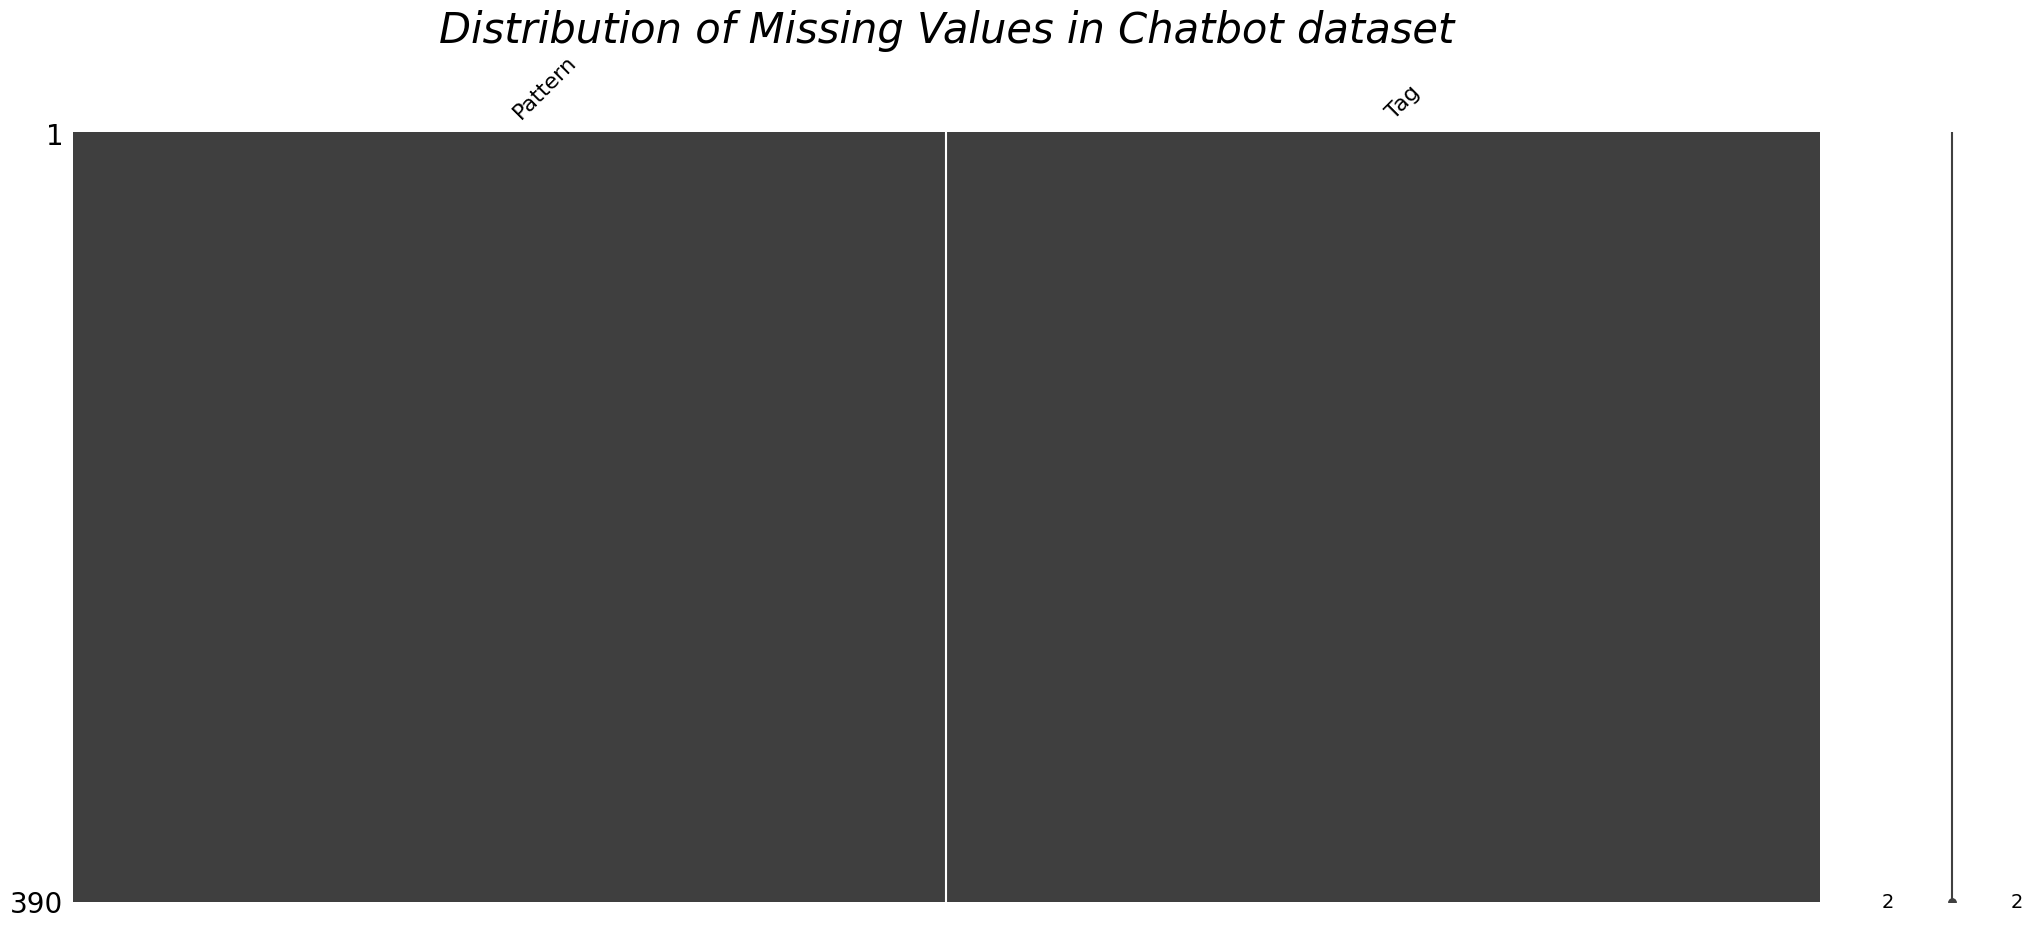

In [17]:
def plot_miss_vals(df, ds_name="df"):
    msno.matrix(df)
    plt.title(f'Distribution of Missing Values in {ds_name} dataset', fontsize=30, fontstyle='oblique')
    plt.show()
    
plot_miss_vals(df, "Chatbot")

<a id="3.8"></a>
### <b>3.8 <span style='color:#B21010'>||</span> Visualize the distrbution of our Classes</b>

In [18]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

    plt.show()

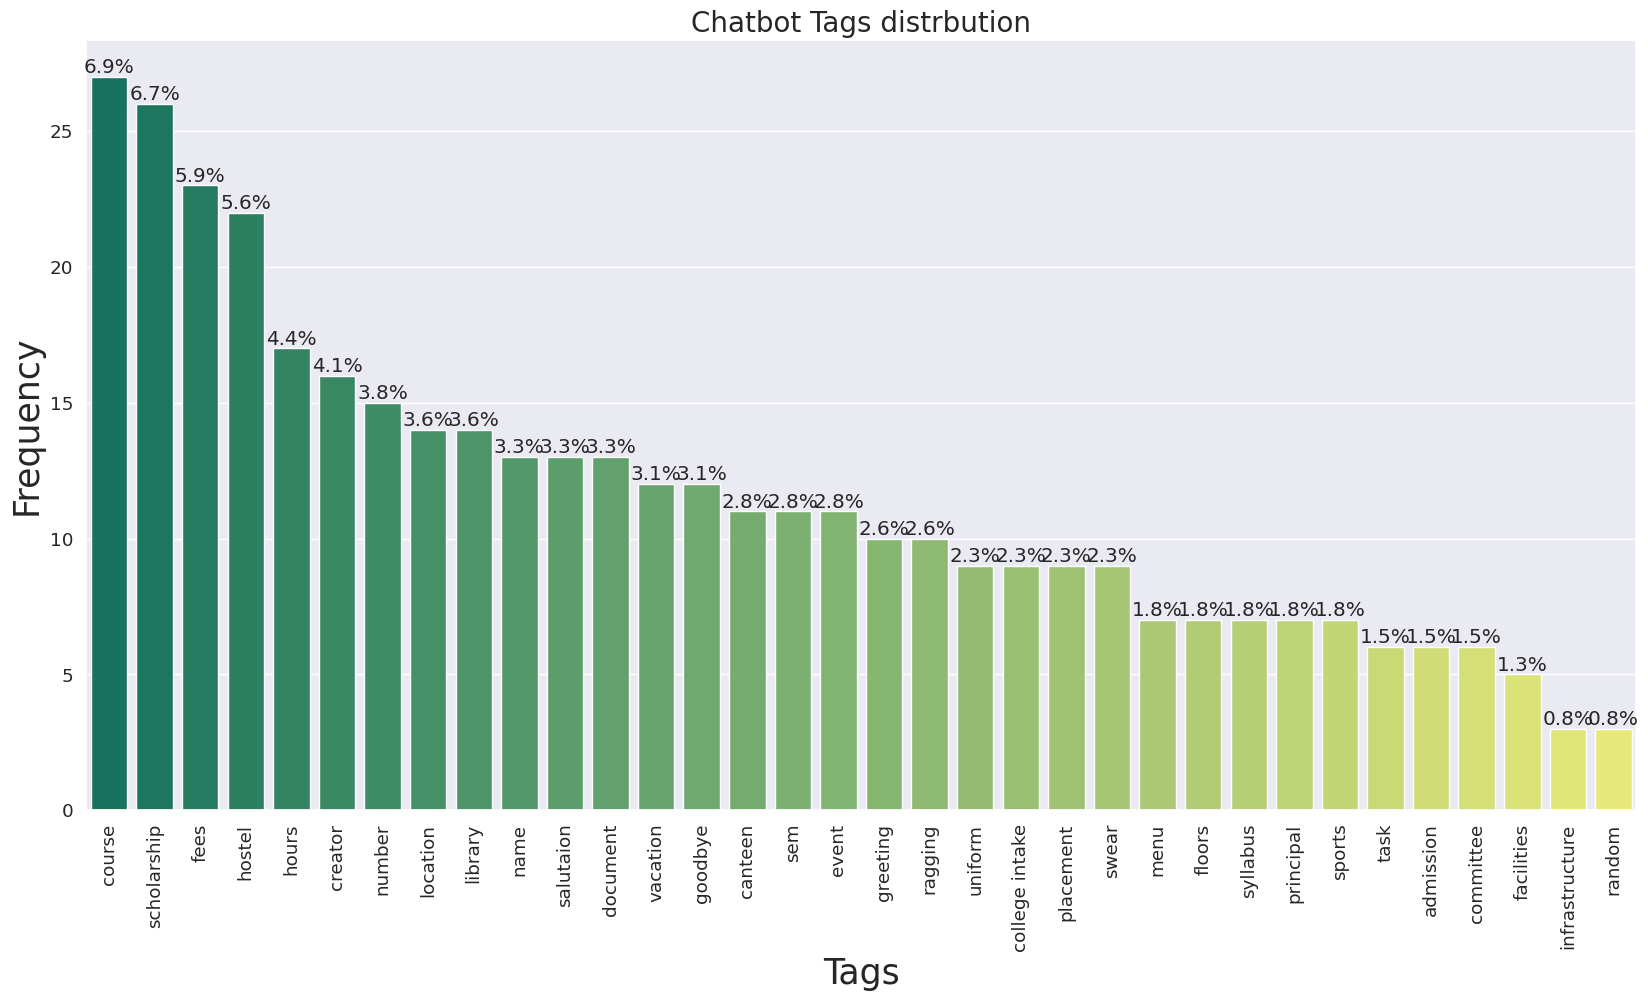

In [19]:
sns.set(font_scale = 1.2)
order = df['Tag'].value_counts().index
count_plot(df['Tag'], df, "Chatbot Tags distrbution", "Tags", "Frequency", 20,10, order=order,rotation=True, palette="summer")

In [9]:
stemmer = PorterStemmer()
ignore_words=['?', '!', ',', '.']

def preprocess_pattern(pattern):
    words = word_tokenize(pattern.lower())
    stemmed_words = [stemmer.stem(word) for word in words if word not in ignore_words]
    return " ".join(stemmed_words)  

df['Pattern'] = df['Pattern'].apply(preprocess_pattern)

In [10]:
df.head()

,Pattern,Tag
0,hi,greeting
1,how are you,greeting
2,is anyon there,greeting
3,hello,greeting
4,good day,greeting


In [22]:
print(df['Pattern'].isnull().sum())

0


<a id="3.9"></a>
### <b>3.9 <span style='color:#B21010'>||</span> Display Word Cloud</b>

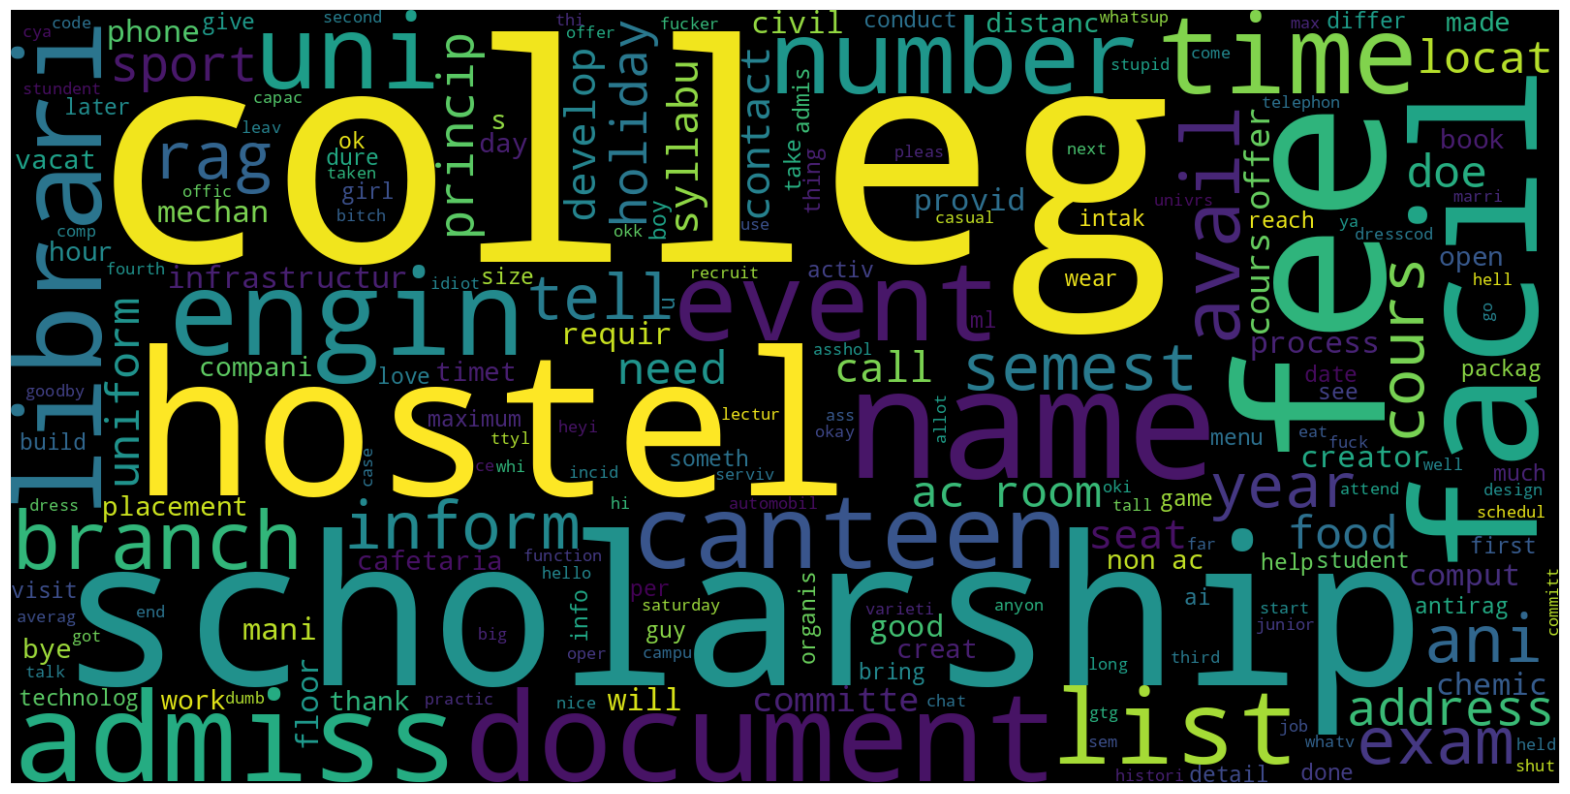

In [23]:
plt.figure(figsize=(20, 20)) 
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df['Pattern']))
plt.imshow(wc, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show()

<a id="3.10"></a>
### <b>3.10 <span style='color:#B21010'>||</span> Distrbution of Number of letters in each text</b>

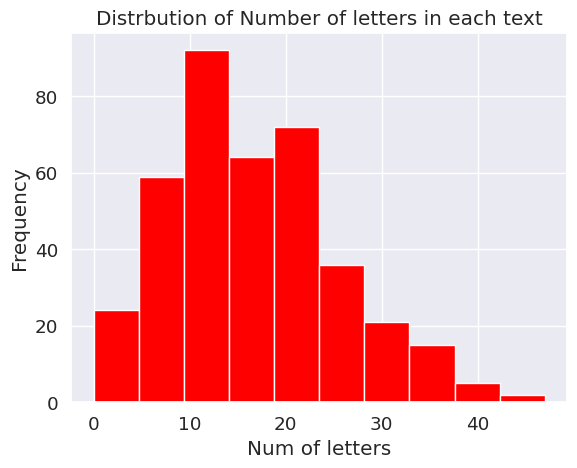

In [24]:
letters_len=df['Pattern'].str.len()
plt.hist(letters_len,color='red')
plt.title("Distrbution of Number of letters in each text")
plt.xlabel("Num of letters")
plt.ylabel("Frequency")
plt.show()

<a id="3.11"></a>
### <b>3.11 <span style='color:#B21010'>||</span> Distrbution of Number of words in each text</b>

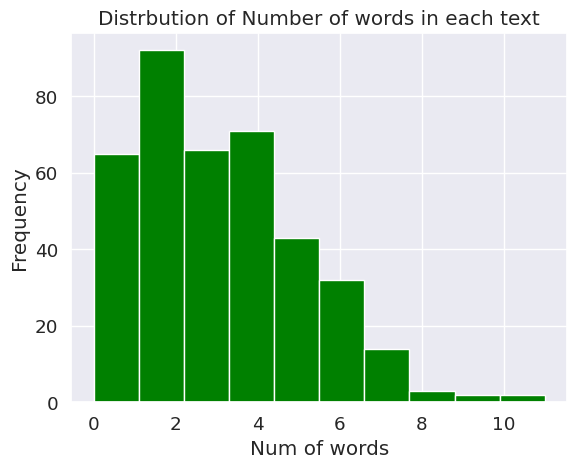

In [25]:
words_len=df['Pattern'].str.split().map(lambda x: len(x))
plt.hist(words_len,color='green')
plt.title("Distrbution of Number of words in each text")
plt.xlabel("Num of words")
plt.ylabel("Frequency")
plt.show()

<a id="3.12"></a>
### <b>3.12 <span style='color:#B21010'>||</span> Visualize Average word length in each text</b>

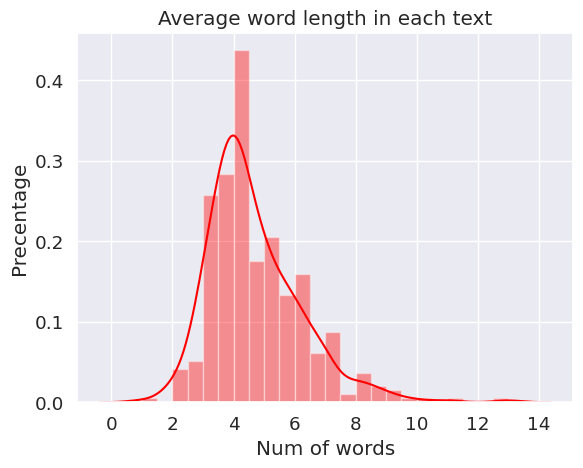

In [26]:
word=df['Pattern'].str.split().apply(lambda x : [len(i) for i in x])
word = word.map(lambda x: np.mean(x))
sns.distplot(word,color='red')
plt.title("Average word length in each text")
plt.xlabel("Num of words")
plt.ylabel("Precentage")
plt.show()

<a id="3.13"></a>
### <b>3.13 <span style='color:#B21010'>||</span> Visualize top words</b>

In [27]:
def get_corpus(series):
    words = []
    for text in series:
        for word in text.split():
            words.append(word.strip())
    return words

corpus = get_corpus(df.Pattern)
corpus[:5]

['hi', 'how', 'are', 'you', 'is']

In [28]:
print(f"dataset contains {len(corpus)} words")

dataset contains 1298 words


In [29]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'colleg': 71,
 'is': 68,
 'what': 59,
 'the': 45,
 'you': 35,
 'of': 30,
 'in': 29,
 'for': 26,
 'scholarship': 26,
 'are': 25}

In [30]:
def get_top_text_ngrams(corpus, n,g):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

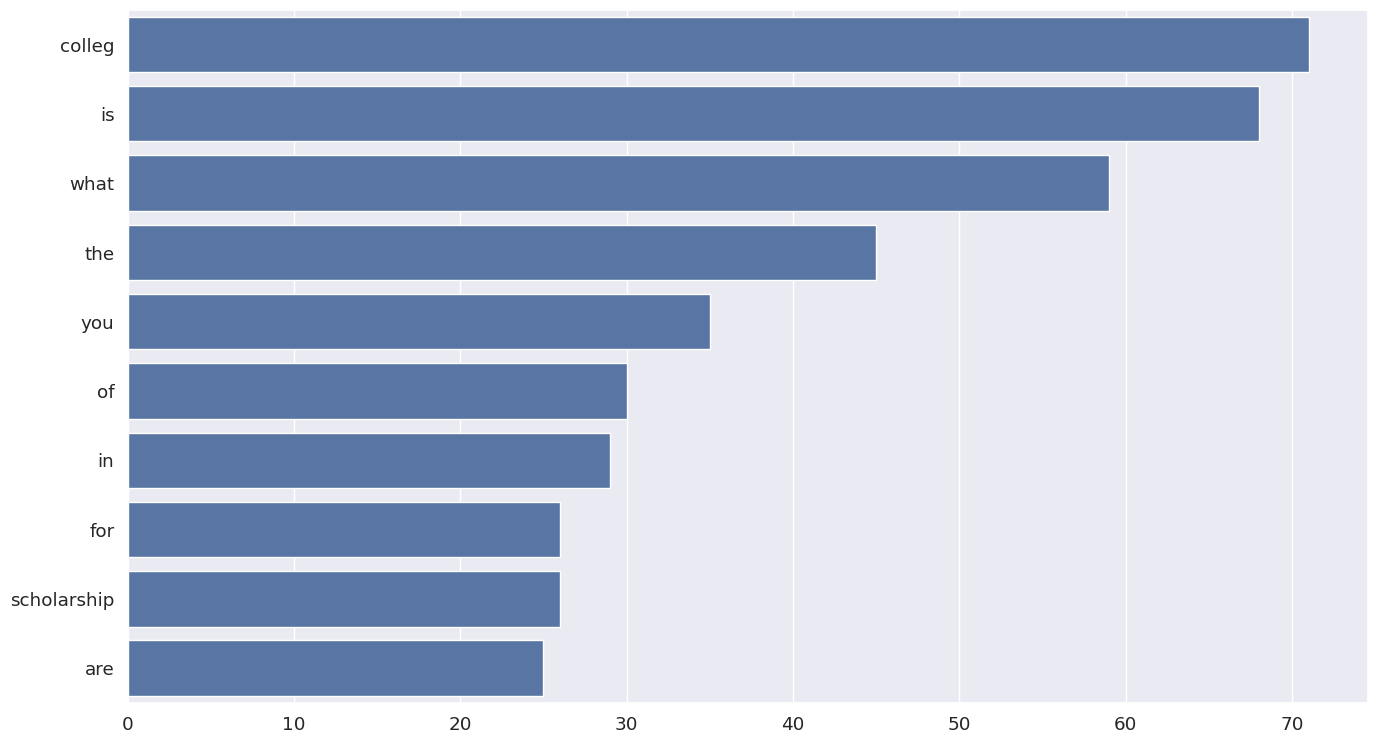

In [31]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.Pattern,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()));

<a id="4"></a>
## <b>4 <span style='color:#B21010'>||</span> Data Preprocessing</b>

In [26]:
df2.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [11]:
labels = df2['Tag'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['greeting',
 'goodbye',
 'creator',
 'name',
 'hours',
 'number',
 'course',
 'fees',
 'location',
 'hostel',
 'event',
 'document',
 'floors',
 'syllabus',
 'library',
 'infrastructure',
 'canteen',
 'menu',
 'placement',
 'principal',
 'sem',
 'admission',
 'scholarship',
 'facilities',
 'college intake',
 'uniform',
 'committee',
 'random',
 'swear',
 'vacation',
 'sports',
 'salutaion',
 'task',
 'ragging']

In [12]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [35]:
id2label

{0: 'greeting',
 1: 'goodbye',
 2: 'creator',
 3: 'name',
 4: 'hours',
 5: 'number',
 6: 'course',
 7: 'fees',
 8: 'location',
 9: 'hostel',
 10: 'event',
 11: 'document',
 12: 'floors',
 13: 'syllabus',
 14: 'library',
 15: 'infrastructure',
 16: 'canteen',
 17: 'menu',
 18: 'placement',
 19: 'principal',
 20: 'sem',
 21: 'admission',
 22: 'scholarship',
 23: 'facilities',
 24: 'college intake',
 25: 'uniform',
 26: 'committee',
 27: 'random',
 28: 'swear',
 29: 'vacation',
 30: 'sports',
 31: 'salutaion',
 32: 'task',
 33: 'ragging'}

In [36]:
label2id

{'greeting': 0,
 'goodbye': 1,
 'creator': 2,
 'name': 3,
 'hours': 4,
 'number': 5,
 'course': 6,
 'fees': 7,
 'location': 8,
 'hostel': 9,
 'event': 10,
 'document': 11,
 'floors': 12,
 'syllabus': 13,
 'library': 14,
 'infrastructure': 15,
 'canteen': 16,
 'menu': 17,
 'placement': 18,
 'principal': 19,
 'sem': 20,
 'admission': 21,
 'scholarship': 22,
 'facilities': 23,
 'college intake': 24,
 'uniform': 25,
 'committee': 26,
 'random': 27,
 'swear': 28,
 'vacation': 29,
 'sports': 30,
 'salutaion': 31,
 'task': 32,
 'ragging': 33}

In [37]:
df2['labels'] = df2['Tag'].map(lambda x: label2id[x.strip()])
df2.head()

,Pattern,Tag,labels
0,Hi,greeting,0
1,How are you?,greeting,0
2,Is anyone there?,greeting,0
3,Hello,greeting,0
4,Good day,greeting,0


<a id="5"></a>
## <b>5 <span style='color:#B21010'>||</span> Split the data into train and test</b>

In [38]:
X = list(df2['Pattern'])
X[:5]

['Hi', 'How are you?', 'Is anyone there?', 'Hello', 'Good day']

In [39]:
y = list(df2['labels'])
y[:5]

[0, 0, 0, 0, 0]

In [40]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 123)

<a id="6"></a>
## <b>6 <span style='color:#B21010'>||</span> Load BERT Pretrained model and Tokenizer</b>

In [ ]:
model_name = "bert-base-uncased"
max_len = 256

tokenizer = BertTokenizer.from_pretrained(model_name, 
                                          max_length=max_len)

model = BertForSequenceClassification.from_pretrained(model_name, 
                                                      num_labels=num_labels, 
                                                      id2label=id2label, 
                                                      label2id = label2id)

<a id="7"></a>
## <b>7 <span style='color:#B21010'>||</span> Transform the data into numerical format</b>

In [42]:
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

In [43]:
full_data = tokenizer(X, truncation=True, padding=True)

<a id="8"></a>
## <b>8 <span style='color:#B21010'>||</span> Build Data Loader</b>


In [44]:
class DataLoader(Dataset):
    
    def __init__(self, encodings, labels):
        
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
               
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)

In [45]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [46]:
fullDataLoader = DataLoader(full_data, y_test)

<a id="9"></a>
## <b>9 <span style='color:#B21010'>||</span> Define Evaluation Metrcies</b>


In [47]:
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

<a id="10"></a>
## <b>10 <span style='color:#B21010'>||</span> Define Training Arguments</b>


In [48]:
training_args = TrainingArguments(
    output_dir='./output', 
    do_train=True,
    do_eval=True,
    num_train_epochs=100,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=16,
    warmup_steps=100,                
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps", 
    load_best_model_at_end=True
)

<a id="11"></a>
## <b>11 <span style='color:#B21010'>||</span> Train the model</b>


In [49]:
import mlflow
import mlflow.sklearn
trainer = Trainer(
    model=model,
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=test_dataloader,            
    compute_metrics= compute_metrics
)

In [50]:
# Start Logging
mlflow.start_run()

# enable autologging
mlflow.sklearn.autolog()

trainer.train()

# Registering the model to the workspace
print("Registering the model via MLFlow")
mlflow.sklearn.log_model(
    sk_model=model,
    registered_model_name="BertChatBot",
    artifact_path="BertChatBot",
)

# Saving the model to a file
mlflow.sklearn.save_model(
    sk_model=model,
    path="BertChatBot/trained_model",
)
###########################
#</save and register model>
###########################

# Stop Logging
mlflow.end_run()

***** Running training *****
  Num examples = 292
  Num Epochs = 100
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1000
Trainer is attempting to log a value of "{0: 'greeting', 1: 'goodbye', 2: 'creator', 3: 'name', 4: 'hours', 5: 'number', 6: 'course', 7: 'fees', 8: 'location', 9: 'hostel', 10: 'event', 11: 'document', 12: 'floors', 13: 'syllabus', 14: 'library', 15: 'infrastructure', 16: 'canteen', 17: 'menu', 18: 'placement', 19: 'principal', 20: 'sem', 21: 'admission', 22: 'scholarship', 23: 'facilities', 24: 'college intake', 25: 'uniform', 26: 'committee', 27: 'random', 28: 'swear', 29: 'vacation', 30: 'sports', 31: 'salutaion', 32: 'task', 33: 'ragging'}" for key "id2label" as a parameter. MLflow's log_param() only accepts values no longer than 250 characters so we dropped this attribute.
Trainer is attempting to log a value of "{'greeting': 0, 'goo

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,3.473700,3.267207,0.163265,0.052463,0.037798,0.110215
100,2.575800,2.032440,0.683673,0.594395,0.608185,0.640625
150,1.021300,1.010326,0.816327,0.776975,0.806250,0.813802
200,0.270800,0.501859,0.897959,0.870647,0.895699,0.883065
250,0.081500,0.425245,0.918367,0.921771,0.944086,0.930108
300,0.045300,0.427923,0.918367,0.921771,0.944086,0.930108
350,0.031800,0.415484,0.928571,0.929312,0.952151,0.935484
400,0.031000,0.432696,0.918367,0.921771,0.944086,0.930108
450,0.021100,0.436194,0.918367,0.921771,0.944086,0.930108
500,0.018200,0.440208,0.918367,0.921771,0.944086,0.930108


Attempted to log scalar metric loss:
3.4737
Attempted to log scalar metric learning_rate:
2.5e-05
Attempted to log scalar metric epoch:
5.0
Attempted to log scalar metric eval_loss:
3.267207145690918
Attempted to log scalar metric eval_Accuracy:
0.16326530612244897
Attempted to log scalar metric eval_F1:
0.05246347236277568
Attempted to log scalar metric eval_Precision:
0.03779849183074989
Attempted to log scalar metric eval_Recall:
0.11021505376344087
Attempted to log scalar metric eval_runtime:
0.3619
Attempted to log scalar metric eval_samples_per_second:
270.799
Attempted to log scalar metric eval_steps_per_second:
19.343
Attempted to log scalar metric epoch:
5.0
Attempted to log scalar metric loss:
2.5758
Attempted to log scalar metric learning_rate:
5e-05
Attempted to log scalar metric epoch:
10.0
Attempted to log scalar metric eval_loss:
2.032440423965454
Attempted to log scalar metric eval_Accuracy:
0.6836734693877551
Attempted to log scalar metric eval_F1:
0.5943946678321679
A

***** Running Evaluation *****
  Num examples = 98
  Batch size = 16
***** Running Evaluation *****
  Num examples = 98
  Batch size = 16
***** Running Evaluation *****
  Num examples = 98
  Batch size = 16
***** Running Evaluation *****
  Num examples = 98
  Batch size = 16
***** Running Evaluation *****
  Num examples = 98
  Batch size = 16
***** Running Evaluation *****
  Num examples = 98
  Batch size = 16
***** Running Evaluation *****
  Num examples = 98
  Batch size = 16
***** Running Evaluation *****
  Num examples = 98
  Batch size = 16
***** Running Evaluation *****
  Num examples = 98
  Batch size = 16
***** Running Evaluation *****
  Num examples = 98
  Batch size = 16
Saving model checkpoint to ./output/checkpoint-500
Configuration saved in ./output/checkpoint-500/config.json
Model weights saved in ./output/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 98
  Batch size = 16
***** Running Evaluation *****
  Num examples = 98
  Batch size = 

<a id="12"></a>
## <b>12 <span style='color:#B21010'>||</span> Evaluate the model</b>


In [51]:
q=[trainer.evaluate(eval_dataset=df2) for df2 in [train_dataloader, test_dataloader]]

pd.DataFrame(q, index=["train","test"]).iloc[:,:5]

***** Running Evaluation *****
  Num examples = 292
  Batch size = 16


Attempted to log scalar metric eval_loss:
0.01348524447530508
Attempted to log scalar metric eval_Accuracy:
0.9965753424657534
Attempted to log scalar metric eval_F1:
0.9983338732818069
Attempted to log scalar metric eval_Precision:
0.9985994397759103
Attempted to log scalar metric eval_Recall:
0.9981617647058824
Attempted to log scalar metric eval_runtime:
1.3742
Attempted to log scalar metric eval_samples_per_second:
212.492
Attempted to log scalar metric eval_steps_per_second:
13.827
Attempted to log scalar metric epoch:
100.0
Attempted to log scalar metric eval_loss:
0.4402083456516266
Attempted to log scalar metric eval_Accuracy:
0.9183673469387755
Attempted to log scalar metric eval_F1:
0.9217707024158637
Attempted to log scalar metric eval_Precision:
0.9440860215053763
Attempted to log scalar metric eval_Recall:
0.9301075268817204
Attempted to log scalar metric eval_runtime:
0.4014
Attempted to log scalar metric eval_samples_per_second:
244.164
Attempted to log scalar metric eva

***** Running Evaluation *****
  Num examples = 98
  Batch size = 16


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.013485,0.996575,0.998334,0.998599,0.998162
test,0.440208,0.918367,0.921771,0.944086,0.930108


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def predict(text):
    
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]

    #return probs, pred_label_idx, pred_label
    return {"label": pred_label, "score": probs[0][pred_label_idx.item()].item() }

In [18]:
text = "Hello"
predict(text)

{'label': 'greeting', 'score': 0.9911870360374451}

<a id="13"></a>
## <b>13 <span style='color:#B21010'>||</span> Save the model</b>


In [54]:
model_path = "chatbot"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

Saving model checkpoint to chatbot
Configuration saved in chatbot/config.json
Model weights saved in chatbot/pytorch_model.bin
tokenizer config file saved in chatbot/tokenizer_config.json
Special tokens file saved in chatbot/special_tokens_map.json


('chatbot/tokenizer_config.json',
 'chatbot/special_tokens_map.json',
 'chatbot/vocab.txt',
 'chatbot/added_tokens.json')

### Create online checkpoint for model without pipeline

### Create Endpoint for model without pipeline

<a id="14"></a>
## <b>14 <span style='color:#B21010'>||</span> Load the model & Create Pipeline</b>


In [14]:
model_path = "chatbot"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
#torch.jit._state.enable()
chatbot= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [11]:
import uuid

# Create a unique name for the endpoint
online_endpoint_name = "chatbot-endpoint-" + str(uuid.uuid4())[:8]

from azure.ai.ml.entities import ManagedOnlineEndpoint

# define an online endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description="Endpoint for Bert Chatbot",
    auth_mode="key",
    tags={
        "training_dataset": "university-info",
    },
)

# create the online endpoint
# expect the endpoint to take approximately 2 minutes.

endpoint = ml_client.online_endpoints.begin_create_or_update(endpoint).result()

endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)

print(
    f'Endpoint "{endpoint.name}" with provisioning state "{endpoint.provisioning_state}" is retrieved'
)

Endpoint "chatbot-endpoint-97f2ceaa" with provisioning state "Succeeded" is retrieved


## Deploying chatbot with UI on endpoint

In [ ]:


from azure.ai.ml.entities import ManagedOnlineDeployment

# Choose the latest version of the registered model for deployment

model = ml_client.models.get(name="BertChatBotPipline", version=1)

# define an online deployment
# if you run into an out of quota error, change the instance_type to a comparable VM that is available.\
# Learn more on https://azure.microsoft.com/en-us/pricing/details/machine-learning/.
blue_deployment = ManagedOnlineDeployment(
    name="blue",
    endpoint_name=online_endpoint_name,
    model=model,
    instance_type="Standard_DS3_v2",
    instance_count=1,
)

# create the online deployment
blue_deployment = ml_client.online_deployments.begin_create_or_update(
    blue_deployment
).result()

# blue deployment takes 100% traffic
# expect the deployment to take approximately 8 to 10 minutes.
endpoint.traffic = {"blue": 100}
ml_client.online_endpoints.begin_create_or_update(endpoint).result()

# return an object that contains metadata for the endpoint
endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)

# print a selection of the endpoint's metadata
print(
    f"Name: {endpoint.name}\nStatus: {endpoint.provisioning_state}\nDescription: {endpoint.description}"
)

# existing traffic details
print(endpoint.traffic)

# Get the scoring URI
print(endpoint.scoring_uri)

In [ ]:
# test the blue deployment with the sample data
ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name="blue",
    request_file="./deploy/sample-request.json",
)

## Save model with pipeline and create batch endpoint

In [14]:
from azure.ai.ml.entities import BatchEndpoint, ModelBatchDeployment, ModelBatchDeploymentSettings, PipelineComponentBatchDeployment, Model, AmlCompute, Data, BatchRetrySettings, CodeConfiguration, Environment, Data
from azure.ai.ml.constants import AssetTypes, BatchDeploymentOutputAction

model_path = "model"
chatbot.save_pretrained(model_path)

model_name = 'BertChatBotPipline'
model = ml_client.models.create_or_update(
    Model(name=model_name, path='model', type=AssetTypes.CUSTOM_MODEL)
)

Your file exceeds 100 MB. If you experience low speeds, latency, or broken connections, we recommend using the AzCopyv10 tool for this file transfer.

Example: azcopy copy '/mnt/batch/tasks/shared/LS_root/mounts/clusters/tanushgoel031/code/Users/tanushgoel03/model' 'https://bertchatbot6523914846.blob.core.windows.net/azureml-blobstore-cfe064dd-35ba-4383-a283-017638098069/LocalUpload/3ea4635067e564edb382c98a472e0d29/model' 

See https://docs.microsoft.com/azure/storage/common/storage-use-azcopy-v10 for more information.


In [13]:
chatbot("Hello")

[{'label': 'greeting', 'score': 0.9911869168281555}]

<a id="15"></a>
## <b>15 <span style='color:#B21010'>||</span> Chat with the Chatbot</b>


### Test Deployment

In [6]:
ml_client.online_deployments.get_logs(
    name="bertchatbotpipeline-1", endpoint_name="chatbot-endpoint-97f2ceaa", local=True, lines=50
)


LocalEndpointNotFoundError: Local deployment (chatbot-endpoint-97f2ceaa / bertchatbotpipeline-1) does not exist.

In [7]:
import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.

# Request data goes here
# The example below assumes JSON formatting which may be updated
# depending on the format your endpoint expects.
# More information can be found here:
# https://docs.microsoft.com/azure/machine-learning/how-to-deploy-advanced-entry-script
data = {"data":"hey"}

body = str.encode(json.dumps(data))

url = 'https://chatbot-endpoint-97f2ceaa.eastus.inference.ml.azure.com/score'
# Replace this with the primary/secondary key, AMLToken, or Microsoft Entra ID token for the endpoint
api_key = 'hopwmiqdXuguiFVzBvXEi0dc1lwymo5A'
if not api_key:
    raise Exception("A key should be provided to invoke the endpoint")

# The azureml-model-deployment header will force the request to go to a specific deployment.
# Remove this header to have the request observe the endpoint traffic rules
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key), 'azureml-model-deployment': 'bertchatbotpipeline-1' }

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
    print(json.loads(result.decode()))
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(error.read().decode("utf8", 'ignore'))

b'{"label": "greeting", "score": 0.9910455346107483, "id": 0}'
{'label': 'greeting', 'score': 0.9910455346107483, 'id': 0}


In [2]:
#input = Input(type=AssetTypes.URI_FOLDER, path="data")

online_endpoint_name= "chatbot-endpoint-97f2ceaa"

endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)
ml_client.online_endpoints.invoke(
    endpoint_name= online_endpoint_name,
    request_file="sample.json",
)



'{"label": "sports", "score": 0.9885880947113037, "id": 30}'

In [29]:
def chat(chatbot):
    
    print("Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..")
    print("Type 'quit' to exit the chat\n\n")
    
    text = input("User: ").strip().lower()
    
    while(text != 'quit'):

        score = chatbot(text)[0]['score']
        
        if score < 0.8:
            print("Chatbot: Sorry I can't answer that\n\n")
            text = input("User: ").strip().lower()
            continue
        
        label = label2id[chatbot(text)[0]['label']]
        response = random.choice(intents['intents'][label]['responses'])
        
        print(f"Chatbot: {response}\n\n")
            
        text = input("User: ").strip().lower()


In [30]:
chat(chatbot)

Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..
Type 'quit' to exit the chat


Chatbot: Our university encourages all-round development of students and hence provides sports facilities in the campus. For more details visit here: https://ucirvinesports.com/


Chatbot: For hostel detail visit https://housing.uci.edu/ here


Chatbot: To look at schedule of classes look at: https://www.reg.uci.edu/perl/WebSoc




<a id="16"></a>
## <b>16 <span style='color:#B21010'>||</span>Notes</b>